In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
%matplotlib inline
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import sqrt, cos, sin, pi
from numpy.fft import fft, ifft, rfft, irfft
from tqdm import tqdm
import time

print(tf.__version__)

2.2.0


- 1d closure ([Hammett & Perkins 1990 PRL](https://w3.pppl.gov/~hammett/refs/1990/Hammett_90_PRL_Landau_fluid_corrected.pdf)) written in the Fourier space:
$$\tilde{q}_{k}=-n_{0}\chi_{1}\frac{\sqrt{2}v_{t}}{\left|k\right|}ik\tilde{T}_{k}$$
where $\tilde{q}_k$ is the heatflux in the k-space,  $\tilde{T}_k$ is the temperature fluctuation in the k-space, $\chi_{1}=\frac{2}{\sqrt{\pi}}$, $n_0$ is the background density, $v_t=\sqrt{T_0/m}$ is the thermal speed.
- input/feature: $\tilde{T}$ in the real-space
- output/label: $\tilde{q}$ in the real-space computed (after fft/ifft) from the closue using $\tilde{T}$
- reference: [Ma+2020POP](http://arxiv.org/abs/1909.11509)

### Generate data

In [3]:
nsamples_train = 10000
nsamples_test = 100
nsamples = nsamples_train + nsamples_test

In [4]:
# physics parameters that define the input (feature) and output (label)
n0 = 1.
vt = 1.
chi1 = 2. / sqrt(pi)

lx = 2. * pi
nx = 128
kmax = 8

In [5]:
def make_modes(x, kmax, magnitude=1.):
    """Make many sinusoidal modes with random amplitudes and phases.

    Args:
        x: 1d spatial coordinates.
        kmax: k = 1, 2, ..., kmax.

    Returns:
        modes: Superposition of all modes.
    """
    A = np.random.random((kmax)) * magnitude
    phi = np.random.random((kmax)) * pi * 2
    modes = np.zeros_like(x)
    for k in range(1, kmax):
        A_k = A[k]
        phi_k = phi[k]
        modes += A_k * np.cos(k * x + phi_k)
    return modes


def make_training_data():
    x = np.linspace(0, lx, nx)
    k = np.fft.fftfreq(nx, d=lx/nx) * 2. * pi

    T_all = []
    q_all = []

    coeff_q = -n0 * chi1 * sqrt(2) * vt * 1j * np.sign(k)

    for isample in tqdm(range(nsamples)):
        # Temperature flucutations in real space, T(x)
        T = make_modes(x, kmax)
        # Temperature fluctuations in Fourier spacer, T(k)
        Tk = fft(T)
        # heatflux fluctuation in Fourier space, q(k)
        qk = coeff_q * Tk
        # heatflux fluctuation in real space, q(x)
        q = ifft(qk).real

        # append real-space input/output of this sample
        T_all.append(T)
        q_all.append(q)

    # convert to ndarray of shape (nsamples, nx)
    T_all = np.array(T_all)
    q_all = np.array(q_all)

    return T_all, q_all


def normalize(arr):
    # all data have mean=0
    # XXX use the same max
    return arr / abs(arr).max()

In [6]:
T, q = make_training_data()

100%|██████████| 10100/10100 [00:01<00:00, 8495.72it/s]


In [7]:
T = normalize(T)
q = normalize(q)

In [8]:
train_data = T[:nsamples_train, ...]
train_labels = q[:nsamples_train, ...]

test_data = T[nsamples_train:, ...]
test_labels = q[nsamples_train:, ...]

### Create the model

In [9]:
num_nodes = 256
model = keras.Sequential([
    layers.Dense(num_nodes,
                 activation='relu',
                 input_shape=(train_data.shape[1], )),
    layers.Dense(num_nodes, activation='relu'),
    layers.Dense(train_labels.shape[1], activation='linear')
])

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy', 'mae', 'mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
Total params: 131,712
Trainable params: 131,712
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [10]:
EPOCHS = 500  # How many times we go through the entire dataset
validation_split = 0.05  # fraction of data to be used as live validation


# https://keras.io/guides/writing_your_own_callbacks/
class PrintLogs(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.time_begin = time.time()

    def on_epoch_end(self, epoch, logs):
        if epoch >0 and (epoch+1) % 100 == 0:
            info = ''
            info += 'EPOCH {}'.format(epoch)
            dt = time.time() - self.time_begin
            dt_per_epoch = dt / (epoch + 1)
            info +='; time total {:g}s per-epoch {:g}s:'.format(dt, dt_per_epoch)
            log_epoch = [
                '{} {:.1e}'.format(key, logs[key]) for key in logs.keys()
            ]
            info += '; '.join(log_epoch)
            print(info)


callbacks = [
    PrintLogs(),
]

# https://keras.io/api/models/model_training_apis/#fit-method
history = model.fit(train_data,
                    train_labels,
                    epochs=EPOCHS,
                    validation_split=validation_split,
                    verbose=0,
                    callbacks=callbacks)

EPOCH 99time total 60.88s per-epoch 0.6088s:loss 3.2e-05; accuracy 9.0e-01; mae 4.3e-03; mse 3.2e-05; val_loss 4.3e-05; val_accuracy 9.0e-01; val_mae 5.1e-03; val_mse 4.3e-05
EPOCH 199time total 126.216s per-epoch 0.63108s:loss 6.5e-06; accuracy 9.6e-01; mae 1.9e-03; mse 6.5e-06; val_loss 3.8e-06; val_accuracy 9.9e-01; val_mae 1.5e-03; val_mse 3.8e-06
EPOCH 299time total 191.262s per-epoch 0.637541s:loss 9.6e-06; accuracy 9.5e-01; mae 2.4e-03; mse 9.6e-06; val_loss 3.2e-05; val_accuracy 9.4e-01; val_mae 4.5e-03; val_mse 3.2e-05
EPOCH 399time total 255.719s per-epoch 0.639298s:loss 4.3e-06; accuracy 9.7e-01; mae 1.6e-03; mse 4.3e-06; val_loss 9.3e-06; val_accuracy 9.8e-01; val_mae 2.3e-03; val_mse 9.3e-06
EPOCH 499time total 321.097s per-epoch 0.642193s:loss 6.4e-06; accuracy 9.6e-01; mae 1.9e-03; mse 6.4e-06; val_loss 7.1e-06; val_accuracy 9.7e-01; val_mae 2.0e-03; val_mse 7.1e-06


### Benchmark the model

In [11]:
# Use the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,mae,mse,val_loss,val_accuracy,val_mae,val_mse,epoch
495,0.000008,0.959263,0.002211,0.000008,0.000005,0.986,0.001717,0.000005,495
496,0.000016,0.943895,0.002928,0.000016,0.000018,0.954,0.003320,0.000018,496
497,0.000006,0.964316,0.001783,0.000006,0.000003,0.978,0.001414,0.000003,497
498,0.000007,0.963263,0.001929,0.000007,0.000004,0.960,0.001506,0.000004,498
499,0.000006,0.962105,0.001863,0.000006,0.000007,0.968,0.002033,0.000007,499


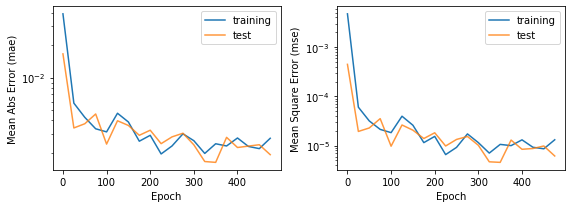

In [12]:
def plot_history(history, step=25):
    fig = plt.figure(figsize=(12, 3))
    hist = pd.DataFrame(history.history).iloc[::step]
    hist['epoch'] = history.epoch[::step]

    plt.subplot(131)
    plt.semilogy(hist['epoch'], hist['mae'], label='training')
    plt.semilogy(hist['epoch'], hist['val_mae'], label='test', alpha=0.8)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error (mae)')

    plt.subplot(132)
    plt.semilogy(hist['epoch'], hist['mse'], label='training')
    plt.semilogy(hist['epoch'], hist['val_mse'], label='test', alpha=0.8)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error (mse)')

    plt.tight_layout()


plot_history(history)

In [21]:
# Compute the overall scores of the model
scores = model.evaluate(test_data, test_labels, verbose=1)

4/4 [==============================] - 0s 9ms/step - loss: 7.6621e-06 - accuracy: 0.9900 - mae: 0.0021 - mse: 7.6621e-06


In [14]:
test_predictions = model.predict(test_data)

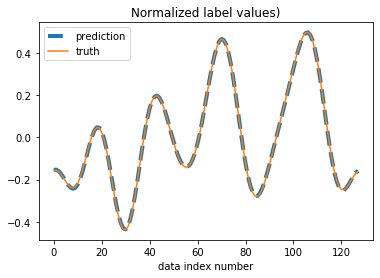

In [45]:
# compare truth and prediction for one or more test samples
for itest in range(1):
    plt.figure()
    plt.plot(test_predictions[itest, :], lw=4, ls='--', label='prediction')
    plt.plot(test_labels[itest, :], label='truth')
    plt.legend()
    plt.xlabel('data index number')
    plt.title('Normalized label values)')

(-1.1, 1.1, -1.1, 1.1)

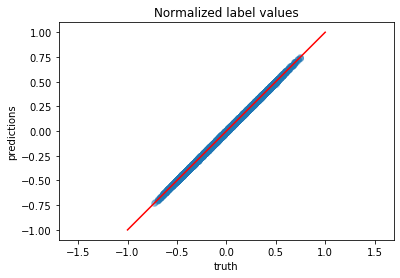

In [60]:
# do the 45-degree plot; close to the diagonal == good
plt.plot((-1, 1), (-1, 1), c='r')
plt.scatter(test_labels, test_predictions, alpha=0.3)
plt.xlabel('truth')
plt.ylabel('predictions')
plt.title('Normalized label values')
plt.axis('equal')

### Save the model

In [17]:
model_filename = 'closure-1d-model.h5'
model.save(model_filename)

In [19]:
import h5py

model_file = h5py.File(model_filename, 'r')


def print_obj(name, obj):
    info = ''
    if isinstance(obj, h5py._hl.dataset.Dataset):
        info = str(obj.shape)
    print('{:42s} {:10s} {}'.format(name, info, type(obj)))


model_file.visititems(print_obj)

model_file.close()

model_weights                                         <class 'h5py._hl.group.Group'>
model_weights/dense                                   <class 'h5py._hl.group.Group'>
model_weights/dense/dense                             <class 'h5py._hl.group.Group'>
model_weights/dense/dense/bias:0           (256,)     <class 'h5py._hl.dataset.Dataset'>
model_weights/dense/dense/kernel:0         (128, 256) <class 'h5py._hl.dataset.Dataset'>
model_weights/dense_1                                 <class 'h5py._hl.group.Group'>
model_weights/dense_1/dense_1                         <class 'h5py._hl.group.Group'>
model_weights/dense_1/dense_1/bias:0       (256,)     <class 'h5py._hl.dataset.Dataset'>
model_weights/dense_1/dense_1/kernel:0     (256, 256) <class 'h5py._hl.dataset.Dataset'>
model_weights/dense_2                                 <class 'h5py._hl.group.Group'>
model_weights/dense_2/dense_2                         <class 'h5py._hl.group.Group'>
model_weights/dense_2/dense_2/bias:0       (128,)